## Loading the housing transaction data

In [41]:
import pandas as pd
import requests
import seaborn as sns
from matplotlib import pyplot as plt
from typing import Any

In [17]:
def get_transaction_data(municipality:str) -> pd.DataFrame:
    url:str = "https://asuntojen.hintatiedot.fi/haku/?"

    params: dict[str,Any] = {
        "c": municipality,
        "cr": 1,
        "t": "3",
        "l": "0",
        "z": "3",
        "search": "1",
        "sf": "0",
        "so": "a",
        "renderType": "renderTypeTable",
        "print": 0,
        "submit": "seuraava+sivu+%C2%BB",
    }
    results: pd.DataFrame() = pd.DataFrame()
    page:int = 1
    while True:
        params["z"] = page
        r: requests.Response = requests.get(url=url, params=params)
        df = pd.read_html(r.url)[0]

        df = df.iloc[3:-2, :]
        if len(df) == 0:
            break
        results = pd.concat([results, df], ignore_index=True)
        page += 1

    results.columns = [
        "region",
        "rooms",
        "type",
        "area_m2",
        "price_e",
        "price_per_m2_e",
        "construction_year",
        "floor",
        "elevator",
        "quality",
        "plot_ownership",
        "energy_grade",
    ]
    results = results.dropna()
    for col in ["area_m2", "price_e", "price_per_m2_e", "construction_year"]:
        results[col] = pd.to_numeric(results[col], errors="coerce")
    results["municipality"] = municipality
    return (results)

In [ ]:
if False:
    Helsinki = get_transaction_data(municipality="Helsinki")
    Espoo = get_transaction_data(municipality="Espoo")
    Vantaa = get_transaction_data(municipality="Vantaa")

    Vantaa.to_parquet("./data/vantaa.parquet")
    Espoo.to_parquet("./data/espoo.parquet")
    Helsinki.to_parquet("./data/helsinki.parquet")
    data = pd.concat(
        [
            pd.read_parquet("data/helsinki.parquet"),
            pd.read_parquet("data/espoo.parquet"),
            pd.read_parquet("data/vantaa.parquet")
        ]
    ).dropna(subset="construction_year")
    data.construction_year = data.construction_year.astype(int)
    for col in ["municipality", "energy_grade", "plot_ownership", "quality", "elevator", "type"]:
        data[col] = data[col].astype("category")
    data.to_parquet("./data/HMA.parquet")

In [47]:
data = pd.read_parquet("data/HMA.parquet")
data.head()

,region,rooms,type,area_m2,price_e,price_per_m2_e,construction_year,floor,elevator,quality,plot_ownership,energy_grade,municipality
0,Ruoholahti,1h+kk,kt,2300.0,170000.0,7391.0,1926,3/5,on,tyyd.,oma,F2018,Helsinki
1,Taka-töölö,"1h,kk",kt,2400.0,155000.0,6458.0,1940,2/3,ei,huono,oma,E2018,Helsinki
2,Taka-töölö,"1h, kk, kph",kt,2700.0,169000.0,6259.0,1937,4/7,on,tyyd.,oma,D2018,Helsinki
3,Munkkivuori,1h+kk,kt,2800.0,164000.0,5857.0,1957,2/3,ei,tyyd.,oma,E2018,Helsinki
4,"Laajasalo, yliskylä",1h+kk+kph,kt,2950.0,128200.0,4346.0,1974,2/8,on,tyyd.,oma,E2018,Helsinki


<Axes: >

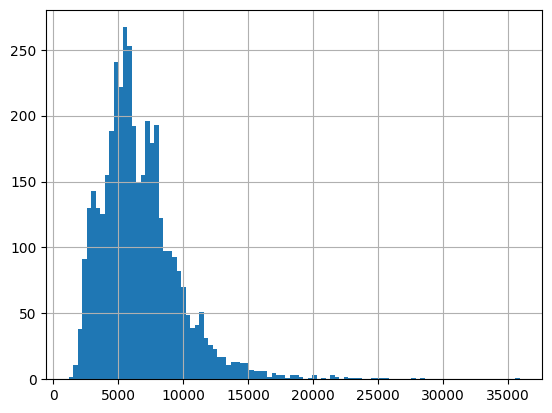

In [48]:
data.area_m2.hist(bins=100)